<a href="https://colab.research.google.com/github/amadords/Projetos-Publicos/blob/master/CRM_(RFM_Analysis)_Outra_abordagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CRM (RFM Analysis) - Outra abordagem**
---



[![LinkedIn](https://img.shields.io/badge/LinkedIn-DanielSousaAmador-cyan.svg)](https://www.linkedin.com/in/daniel-sousa-amador)
[![GitHub](https://img.shields.io/badge/GitHub-amadords-darkblue.svg)](https://github.com/amadords)
[![Medium](https://img.shields.io/badge/Medium-DanielSousaAmador-white.svg)](https://daniel-s-amador.medium.com/)


![img](https://image.freepik.com/vetores-gratis/conceito-de-ilustracao-isometrica-de-solucao-de-crm_108061-581.jpg)

O presente material serve como material de apoio para o artigo do medium [CRM e Ciência de Dados]().

É uma tradução livre do material, em turco, que pode ser visualizado [aqui](https://www.kaggle.com/emreoksuz/crm-analytics-rfm-analysis-cltv).

### **Dicionário de variáveis**

* `Invoice` -  Número da fatura. Número único para cada fatura. Se este código começar com C, indica que a transação foi cancelada.

* `StockCode` - Código do produto. Número único para cada produto.

* `Description` - Nome do produto

* `Quantity` - Número de itens. Indica quantos produtos nas faturas são vendidos.

* `InvoiceDate` - Data e hora da fatura.

* `Price` -  Preço do item

* `CustomerID` - Número de cliente único

* `Country` -  Nome do país. O país onde o cliente mora.

**Instalação das bibliotecas**

In [ ]:
!pip install xlrd -q
!pip install openpyxl -q
!pip install lifetimes -q

# Estamos importando as bibliotecas necessárias no projeto.import datetime as dt

import datetime as dt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter


# Para observar todas as colunas e linhas na saída;pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# O código onde colocaremos as colunas lado a lado para evitar que as colunas deslizem para o fundo na saída.pd.set_option('display.expand_frame_repr', False)

     |████████████████████████████████| 593kB 16.5MB/s 


# **1 - Data Understanding**

**Lendo os dados**

In [ ]:
PATH = 'https://www.dropbox.com/s/3agu97zwezok8qf/CRM.xlsx?dl=1'

df_original = pd.read_excel(PATH, sheet_name = "Year 2009-2010")

**Fazendo cópia dos dados**

In [ ]:
df = df_original.copy()

**Examinamos os primeiros 5 valores de observação no conjunto de dados**

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


**Quantas linhas e quantas colunas existem nos dados?**

In [ ]:
df.shape

(525461, 8)

**Quantos produtos exclusivos existem?**

In [ ]:
df["Description"].nunique()

4681

**Quantos produtos têm?**

In [ ]:
df["Description"].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    3549
REGENCY CAKESTAND 3 TIER              2212
STRAWBERRY CERAMIC TRINKET BOX        1843
PACK OF 72 RETRO SPOT CAKE CASES      1466
ASSORTED COLOUR BIRD ORNAMENT         1457
Name: Description, dtype: int64

**Quais são os 5 produtos mais pedidos?**

> Pegando os nomes dos produtos `Description` no conjunto de dados, obtemos a soma das quantidades do produto `Quantity`.

> Classificamos do grande ao pequeno de acordo com a quantidade do produto. Estamos examinando as primeiras 5 observações com a operação `.head()`.

In [ ]:
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WHITE HANGING HEART T-LIGHT HOLDER,57733
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54698
BROCADE RING PURSE,47647
PACK OF 72 RETRO SPOT CAKE CASES,46106
ASSORTED COLOUR BIRD ORNAMENT,44925


**Quais são os 5 produtos mais caros?**

> Pegando os nomes dos produtos `Description` no conjunto de dados, obtemos o valor máximo dos preços dos produtos `Price`.

> Classificamos do grande ao pequeno de acordo com o preço do produto `Price`. Estamos examinando as primeiras 5 observações com a operação `.head()`.

In [ ]:
df.groupby("Description").agg({"Price":"max"}).sort_values("Price", ascending = False).head()

,Price
Description,
Manual,25111.09
Bank Charges,18910.69
AMAZON FEE,13541.33
Adjustment by john on 26/01/2010 17,5117.03
Discount,1269.51


**De qual país os clientes com mais compras compram?**

In [ ]:
df.groupby("Country").agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False).head()

,Quantity
Country,
United Kingdom,4429046
Denmark,227030
EIRE,188704
Netherlands,181823
Germany,107133


# **2 - Data Preperation**

**Verificando se temos alguma observação faltando.**

In [ ]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

**Também posso operar em observações ausentes, mas há muitas observações em meu conjunto de dados.**

> Específico para este projeto, eu excluo diretamente as observações ausentes do conjunto de dados.
> `eixo = 0` são as linhas e o `eixo = 1` coluna. Se `inplace = True`, torna este processo permanente sem atribuição.

> Com a função `isnull`, eu verifico novamente as observações ausentes. Como pode ser visto, eliminamos as observações que faltavam.


In [ ]:
df.dropna (axis = 0, inplace = True)
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

**Faturando Os valores que começam com "C" na variável `Invoice` representam as faturas que são devolvidas**

> Como não faremos uma análise das faturas devolvidas neste estudo,
Na variável `Invoice`, selecionamos as observações que contêm C e as atribuímos como df novamente.

In [ ]:
df = df[~df["Invoice"].str.contains("C", na=False)]


**Após essas operações, vamos examinar o número de linhas e colunas**

In [ ]:
df.shape

(407695, 8)

**Nesta seção, é importante examinar as estatísticas descritivas do conjunto de dados.**

> Se uma violação for observada, precisamos tomar medidas para corrigi-la.

> Quando examinamos as estatísticas da quantidade do produto `Quantity` e o preço do produto abaixo.

> Existe uma discrepância séria entre os 99% e os valores máximos de ambas as variáveis.

In [ ]:
df.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,407695.0,13.586686,96.842229,1.0,1.00,1.00,2.00,5.00,12.00,36.0,144.00,19152.0
Price,407695.0,3.294188,34.756655,0.0,0.42,0.65,1.25,1.95,4.25,8.5,14.95,10953.5
Customer ID,407695.0,15368.504107,1679.795700,12346.0,12731.00,13044.00,13997.00,15321.00,17138.00,17913.0,18196.00,18287.0


**Continuando a análise, eliminando a discrepância de observação**

> Com a função `outlier_thresholds`, determinamos um valor limite para outliers.

> Definimos um valor limite como o limite inferior e outro superior. Essas observações atípicas estão fora do limite.

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

**Na função `replace_with_thresholds`, substituímos os outliers pelos valores de limite que detectamos na função `outlier_thresholds`**

> Portanto, os outliers agora mudam com os valores de limite no trimestre que definimos.

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
     # dataframe.loc [(dataframe [variável] <limite_inferior), variável] = limite_inferior
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

**Agora podemos eliminar a discrepância tanto na variável de quantidade quanto na variável de preço**


In [ ]:
replace_with_thresholds(df, "Quantity")
replace_with_thresholds(df, "Price")

In [ ]:
df.describe([0.05,0.10,0.25,0.50,0.80,0.95,0.99]).T

,count,mean,std,min,5%,10%,25%,50%,80%,95%,99%,max
Quantity,407695.0,11.907043,28.729349,1.0,1.00,1.00,2.00,5.00,12.00,36.0,144.00,358.50
Price,407695.0,3.005391,3.250550,0.0,0.42,0.65,1.25,1.95,4.25,8.5,14.95,36.94
Customer ID,407695.0,15368.504107,1679.795700,12346.0,12731.00,13044.00,13997.00,15321.00,17138.00,17913.0,18196.00,18287.00


**As variáveis ​​Quantidade e Preço mostram o número de produtos e o preço unitário de cada produto**

> Avaliaremos o preço total da fatura em nosso estudo.

> Para isso, criaremos uma nova variável `TotalPrice` multiplicando as observações nas variáveis `Quantity` e `Price`.

**Depois de todas as etapas de pré-processamento de dados, agora podemos ver as 5 primeiras observações do estado final de nossos dados**

> A variável `TotalPrice` também é vista.

In [ ]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

**Visualizando a nova tabela**

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12.0,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12.0,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48.0,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24.0,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# **3 - Criação de segmentos RFM**

* **RFM** ajuda a determinar estratégias de marketing e vendas baseadas nos clientes, segmentando-os com base em seus hábitos de compra.

* Consiste nas iniciais de 3 métricas de comportamento.

  - **Tempo para retorno**: Tempo decorrido desde o último contato do cliente com a empresa, ou seja, a última compra do cliente.

  (Tempo para retorno = data de hoje - última data de compra)
O ponto que precisamos prestar atenção aqui é o valor de Recência. Neste valor, uma pontuação reversa é feita de acordo com as métricas Frequência e Monetária.

  Quanto mais próximo for o valor de recência, quanto mais perto da data em que o cliente fez a última compra, mais valioso será para nós. Portanto, quanto menor for o resultado da fórmula de Recência acima, maior será a pontuação na pontuação para nós.

  - **Frequência**: Mostra o número total de compras do cliente.

  - **Valor Monetário**: É o gasto total realizado pelo cliente em suas compras.

Quanto mais altos os valores das métricas Frequência e Valor Monetário, maior será a pontuação do RFM.

**Calculando a métrica de recência**

> Definiremos uma data de referência para Recência e subtrairemos as últimas datas de compra dos clientes dessa data de referência.

    (Tempo para retorno = data de hoje - última data de compra)

> Como vamos fazer isso?

  Em primeiro lugar, definiremos uma data de referência. A razão para isso é determinar a data de hoje na fórmula de recência. A situação que chamamos de data de hoje é na verdade o que queremos saber há quantos dias o cliente fez uma compra pela última vez. Para isso, podemos atingir nosso valor de Recência quando determinamos a data de hoje como 1-2 dias após o dia máximo do conjunto de dados e subtraímos a última data de compra para cada cliente a partir dessa data.

  A lógica para determinar os próximos 1-2 dias é evitar que os valores de recência cheguem a "0" devido à subtração na fórmula de recência de nossos clientes que fizeram uma compra no último dia do conjunto de dados.
  Usaremos a variável da data da `InvoiceDate`, pois o tempo para retorno representa a última compra do cliente.

  Tomando groupby com base nos clientes `CustomerID`, pegaremos a função `lambda` da variável `InvoiceDate` e subtrairemos a data de referência que determinamos da última data de compra de cada cliente.

    dataframe.groupby('CustomerID').agg(('InvoiceDate': lambda data: (today_date - date.max()).days

**Calculando Métrica de Frequência**

Como a frequência se refere ao número total de compras do cliente, usaremos a variável de fatura `Invoice`.

  Os clientes contarão o valor único de cada número de fatura, considerando groupby com base em `CustomerID`, navegando na variável da função `lambda`  em `Invoice`. Veremos quantas compras diferentes o cliente fez.
    
    dataframe.groupby('CustomerID').agg(('Invoice': lambda num: num.nunique()})

**Calculando a métrica do valor monetário**

Como Monetário se refere ao gasto total realizado pelo cliente em suas compras, na linha 20, usaremos a variável `TotalPrice` que criamos multiplicando as variáveis ​​`Quantity` e `Price`.

  Os clientes pegarão groupby com base em `CustomerID` e procurarão a variável da função lambda `TotalPrice` e nos darão o total de cada valor de compra do cliente relevante. Veremos o gasto total feito pelo cliente.

    dataframe.groupby('CustomerID').agg(( "TotalPrice": lambda price: price.sum()})

**Criaremos os scores de Recency (recência - tempo para retorno), Frequency (frequência) e Monetary (valor monetário) com as variáveis ​​do conjunto de dados**

> Visualizando os dados atuais.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407695 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  float64       
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
 8   TotalPrice   407695 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 31.1+ MB


**Vamos ver a data máxima no conjunto de dados. Vamos definir uma data de referência de acordo**

> Nossa data máxima é 12/09/2011

In [ ]:
df["InvoiceDate"].max()

Timestamp('2010-12-09 20:01:00')

**Vamos definir uma data de referência. Eu escolho 2 dias após a data máxima**

In [ ]:
today_date = dt.datetime(2011, 12, 11)

**Agora podemos criar nossa Tabela RFM que consistirá em valores de recência, frequência e valor monetário**

In [ ]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})

**5 observações da tabela RFM**

> Esta tabela consiste nas variáveis ​​`InvoiceDate`, `Invoice` e `TotalPrice`.

In [ ]:
rfm.head ()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,530,11,372.86
12347.0,368,2,1323.32
12348.0,439,1,222.16
12349.0,408,3,2295.02
12351.0,376,1,300.93


**Nossas variáveis ​​acima agora expressam nossos valores de recência, frequência e monetário**

> Então podemos renomear as variáveis. Estou atribuindo novos nomes a *rfm.columns*.

In [ ]:
rfm.columns = ['recency', 'frequency', "monetary"]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,530,11,372.86
12347.0,368,2,1323.32
12348.0,439,1,222.16
12349.0,408,3,2295.02
12351.0,376,1,300.93


**Em nossa tabela rfm que criamos**

> Olhamos para `monetary` e valores de `frequency` para uma finalidade de controle para ver se há algum valor não maior que "0". A razão pela qual faço essa verificação é que os valores de `frequency` e `monetary` não devem ser "0".

> Como resultado do cheque, o cliente fez 1 compra, mas o valor total deixado pelo cliente é "0" unidade. Uma vez que tal situação não será possível, nós a atribuímos como `rfm` para ambas as variáveis ​​maiores que 0.

In [ ]:
rfm[~((rfm["monetary"]) > 0 & (rfm["frequency"] > 0))]

,recency,frequency,monetary
Customer ID,,,
14103.0,666,1,0.0
14827.0,666,1,0.0


In [ ]:
rfm = rfm[(rfm['monetary'] > 0)]

In [ ]:
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,530,11,372.86
12347.0,368,2,1323.32
12348.0,439,1,222.16
12349.0,408,3,2295.02
12351.0,376,1,300.93


**Agora calculamos as métricas RFM**

> Relembrando:

`Tempo para retorno`: refere-se ao período desde a última data de compra de nossos clientes até a data de referência.

`Frequência`: Refere-se ao número total de compras de nossos clientes.

`Monetário`: refere-se ao valor total que os clientes gastam como resultado dessas compras.

> A exemplo: O cliente com *ID 12348* fez compras há 76 dias e fez 4 compras. O valor total restante como resultado dessas aquisições é de 1.770,78 unidades.

> Agora podemos prosseguir para calcular as pontuações RFM.
Cálculo de pontuações RFM

> Para comparar as métricas RFM mais facilmente, forneceremos valores entre 1 e 5 e converteremos as métricas em pontuações RFM. Além disso, estaremos segmentando clientes com 1 muito ruim e 5 muito bom.

> O ponto importante aqui é que usaremos apenas os valores de Recência e Frequência ao definir os segmentos de nossos clientes. Porque o valor monetário não é usado para definir o segmento RFM. As variáveis ​​importantes na definição do segmento Rfm são a data da última compra do nosso cliente e o número de compras efetuadas, sendo dadas pelas variáveis ​​Recência e Frequência, respetivamente.

> Então, como criamos pontuações RFM?

* Com a função `.qcut()`, classificamos a variável em ordem crescente e a dividimos no valor do quarto que desejamos.

* Ao ordenar a variável `recency` de pequeno a grande, daremos 5 pontos ao menor e 1 ponto ao maior, porque o menor número se refere às compras mais próximas, então damos a melhor pontuação ao menor número.
        pd.qcut(rfm['recency'], 5, labels = [5, 4, 3, 2, 1])

* Na variável `requency`, daremos 5 para aquele com o maior número de compras e 1 para aquele com o menor número de compras.
        pd.qcut(rfm('frequency').rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])

**Calculamos as pontuações RFM conforme indicado acima**

> Atribuímos `recency_score` e `frequency_score` como as novas variáveis.

In [ ]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

**Agora criamos RFM Metrics e RFM Scores.**

> Por exemplo, quando interpretamos a tabela abaixo;

O cliente com ID 12347 tem um valor de `recency` de 3, um valor de `frequency` de 7, então o cliente fez a última compra há 3 dias e obteve 5 pontos na pontuação RFM, pois essa é uma métrica importante para mim. Como o número de compras de um mesmo cliente é 7, ele também recebeu 5 pontos como sua pontuação de frequência.

In [ ]:
rfm.head ()

,recency,frequency,monetary,recency_score,frequency_score
Customer ID,,,,,
12346.0,530,11,372.86,2,5
12347.0,368,2,1323.32,5,2
12348.0,439,1,222.16,2,1
12349.0,408,3,2295.02,3,3
12351.0,376,1,300.93,5,1


**Criação de segmentos RFM**

> Depois de criar as pontuações RFM, criaremos os segmentos RFM de acordo com a tabela RFM comumente usada abaixo. Na tabela a seguir, os clientes são divididos em segmentos. Existem 2 métricas nesta tabela como frequência e tempo para retorno. Formamos nossas pontuações nessas 2 métricas. Para 2 métricas, 1 significa muito bom, 5 significa muito ruim.

Também segmentaremos nossos clientes com valores de frequência e tempo para retorno de acordo com as pontuações que criamos a partir de seus comportamentos acima, na tabela abaixo.

> Vamos primeiro examinar algumas classes da tabela:

*  Aqueles na classe `Champions` são nossos clientes mais valiosos. Esta classe tem a última data de compra mais próxima e o maior número de compras.

*  Aqueles que estão na classe de `Loyal Customers` são nossos clientes fiéis. O valor de recência daqueles nesta classe consiste em 3 e 4, e o valor de Frequência consiste em 4 e 5 pontuações.

*  Aqueles na classe `At Risk` representam a classe arriscada. O valor de recência daqueles nesta classe consiste em 1 e 2, e o valor de frequência consiste em 3 e 4 pontuações. Ou seja, já se passou muito tempo desde a última data de compra, e são clientes cujas compras estavam na média há muito tempo.

> Podemos interpretar a tabela desta forma:

![img](https://raw.githubusercontent.com/amadords/images/main/rfm1.png)



Agora criamos nossas pontuações RFM, vamos segmentar nossos clientes de acordo com a tabela acima. Por exemplo, colocaremos nosso cliente com um valor de `Frequency` de 5 e um valor de `Recency` de 5 na classe `Champions`.

**Primeiro, vamos atribuir uma variável de segmento. Usaremos suas somas para criar a tabela acima**

> A razão pela qual foi transformado em `str` é que não faremos adição matematicamente. Vamos apenas justapor os números.

> A tabela abaixo mostra a operação que fizemos na variável `rfm_segment`.

In [ ]:
rfm['rfm_segment'] = rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12346.0,530,11,372.86,2,5,25
12347.0,368,2,1323.32,5,2,52
12348.0,439,1,222.16,2,1,21
12349.0,408,3,2295.02,3,3,33
12351.0,376,1,300.93,5,1,51


**Esta tabela nos diz algo**

> Vamos ver nossos melhores clientes em comportamento de compra, por exemplo.

In [ ]:
rfm[rfm["rfm_segment"] == "55"].head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12415.0,376,7,19460.64,5,5,55
12431.0,374,13,4370.52,5,5,55
12471.0,375,49,20135.59,5,5,55
12472.0,370,13,11308.48,5,5,55
12474.0,379,13,5020.60,5,5,55


**Vamos ver o comportamento de compra de nossos piores clientes**

In [ ]:
rfm[rfm["rfm_segment"] == "11"].head()

,recency,frequency,monetary,recency_score,frequency_score,rfm_segment
Customer ID,,,,,,
12355.0,568,1,488.21,1,1,11
12362.0,739,1,36.94,1,1,11
12366.0,634,1,500.24,1,1,11
12368.0,629,1,917.70,1,1,11
12378.0,563,1,1401.68,1,1,11


**Com a seguinte estrutura de Expressões regulares (Regex)**

> Atribuiremos nossos clientes aos segmentos RFM na tabela colorida que examinamos acima de acordo com suas pontuações RFM.

> Indicamos abaixo, um por um, em qual segmento nossos clientes estarão de acordo com suas pontuações de `recency` e `frequency`. Por exemplo, clientes com valor de `recency` de 1-2 e valor de `frequency` de 3 ou 4 serão atribuídos ao segmento **At_risk**.

In [ ]:
seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

**Substituímos essa estrutura Regex por uma variável chamada `rfm_segment` em nossa tabela RFM e a convertemos em dataframe**

> Em nossa variável `rfm_segment`, podemos ver em qual classe ou segmento nossos clientes pertecem.

In [ ]:
rfm['rfm_segment'] = rfm['rfm_segment'].replace(seg_map, regex=True)

In [ ]:
rfm = rfm[["recency", "frequency", "monetary", "rfm_segment"]]
rfm.head()

,recency,frequency,monetary,rfm_segment
Customer ID,,,,
12346.0,530,11,372.86,cant_loose
12347.0,368,2,1323.32,potential_loyalists
12348.0,439,1,222.16,hibernating
12349.0,408,3,2295.02,need_attention
12351.0,376,1,300.93,new_customers


**Quantos clientes temos nos segmentos?**

> Vamos examinar as estatísticas descritivas dos segmentos.

In [ ]:
rfm[["rfm_segment", "recency", "frequency", "monetary"]].groupby("rfm_segment").agg(["mean","median", "count"])

recency               ...     monetary                
                           mean median count  ...         mean    median count
rfm_segment                                   ...                             
about_to_sleep       418.819242  418.0   343  ...   435.429111   315.980   343
at_risk              517.158756  496.0   611  ...  1089.292367   754.380   611
cant_loose           489.116883  474.0    77  ...  3486.987532  2322.590    77
champions            372.119155  372.0   663  ...  6570.387425  2500.540   663
hibernating          578.885714  578.0  1015  ...   363.962832   245.480  1015
loyal_customers      401.287062  396.0   742  ...  2672.967508  1810.195   742
need_attention       418.265700  418.0   207  ...  1009.158865   723.950   207
new_customers        373.580000  373.5    50  ...   385.877800   258.825    50
potential_loyalists  383.793037  384.0   517  ...   718.512853   522.670   517
promising            390.747126  390.0    87  ...   362.921954   263.380    87

[10 rows x 9 columns]

**Apliquei as operações desta linha para fazer a visualização**

> As operações nesta linha não contêm um código relacionado ao nosso projeto.

In [ ]:
rfm1 = rfm[["rfm_segment", "recency", "frequency", "monetary"]].groupby("rfm_segment").agg(["mean","median", "count"])
rfm1.columns = rfm1.columns.droplevel(0)
rfm1.reset_index(inplace=True)
rfm1.columns = ["rfm_segment","nulo","nulo","count","nulo","nulo","nulo","nulo","nulo","nulo"]
rfm1 = rfm1.sort_values(by="count", ascending=False)

**Gráfico de pizza**

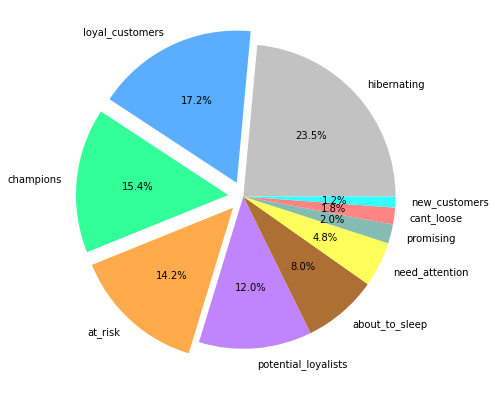

In [ ]:
import matplotlib.pyplot as plt

colors = ['#C2C2C2', '#5BADFF', '#33FF99', '#FFAB4B', 
          '#C184FF', '#AD6F33','#FFFF5B','#85BBB2',
          '#FF8484','#33FFFF']

fig1, ax1 = plt.subplots(figsize=(10,7))

ax1.pie(rfm1["count"] ,labels=rfm1["rfm_segment"].unique() ,colors=colors, 
        explode=[0,0.1,0.1,0.1,0,0,0,0,0,0] ,autopct='%1.1f%%');

**Interpretação do resultado da análise RFM e decisões de ação**

> Concluímos o processo de análise de RFM criando a segmentação de RFM. Analisando as tabelas de estatísticas descritivas com mais detalhes usando os recursos visuais acima. Como resultado da Análise RFM, se pode ver abaixo as interpretações dessas classes e os planos de ação a serem executados para os clientes nesta classe, selecionando os 3 segmentos diferentes que dividi como fatias de pizza na imagem acima.

**Escopo e objetivo**

Como resultado da Análise RFM, a distribuição do número de clientes dos segmentos foi tida em consideração na seleção dos 3 segmentos da tabela.
No segmento em que o cliente tem mais, podemos agir.
Nos dados, o número de clientes particulares entre os anos 2010-2011 é de 4338.

19% desses clientes pertencem a `loyal_Customers`, 15% a `Champions`, 14% a segmentos `at_Risk`.

Embora o grupo `hibernating` seja o grupo com mais clientes, é o grupo com o valor de compra atual mais antigo com uma média de 217 dias. Embora os clientes se encontrem neste grupo, considerando o valor médio de `recency`, este segmento não é considerado em termos de ação por enquanto.

**CLIENTES FIEIS**

Existem 819 pessoas neste grupo.
Eles compraram, em média, 33 dias atrás.

O número médio de compras de clientes deste grupo é de 6. Os clientes neste conjunto de dados fizeram 52% mais compras do que os clientes em todos os segmentos. (Número médio geral de compras 4,27).

O gasto médio do grupo é de £ 2.864,00. Nesse conjunto de dados, eles gastaram 39% a mais do que todos os clientes gastaram.

> *Recomendações de ação*

Ao envolver esse grupo, ele precisa ser incluído no segmento dos Campeões. Existem clientes que estão qualificados para isso.

Este grupo pode ser incentivado aumentando o conteúdo especial no grupo dos Campeões.

Precisamos estar mais em contato com o valor de Recência desse segmento, ou seja, antecipar os tempos de compra.

**CAMPEÕES**

Existem 633 pessoas neste grupo.
Eles compraram, em média, 6 dias atrás.
A média de compras de clientes deste grupo é de 12.
O gasto médio do grupo é de £ 6.857,96.

> *Recomendações de ação*

Podemos recomendar produtos que estão no topo em qualidade e preço para este segmento.

Podemos extrair valor da experiência deles enviando produtos que acabaram de ser lançados no mercado e que serão apresentados aos usuários gratuitamente.
Descontos em roupas, acessórios e locais de alimentação e bebidas contratados podem ser concedidos com cartões especiais para este segmento. Precisamos fazer com que eles se sintam realmente privilegiados.

**EM RISCO**

Existem 593 pessoas neste grupo.
Eles fizeram compras, em média, 153 dias atrás.
O número médio de compras dos clientes deste grupo é de 2,87. Os clientes neste conjunto de dados fizeram 33% menos compras do que os clientes em todos os segmentos. (Número médio geral de compradores é de 4,27)
O gasto médio do grupo é de £ 1.084,54. Nesse conjunto de dados, eles gastaram 47% menos do que todos os clientes  gastaram.

> *Recomendações de ação*

Pode ser contactado por SMS.
As chances de os clientes desse grupo mudarem para o grupo de sono são muito altas. Descontos especiais e campanhas podem ser definidos para este grupo.

# **4 - CLTV calculada**



Calcularemos o valor de cada cliente em nossa empresa comparando os ganhos totais de todos os clientes em nossa empresa, o número total de pedidos e o número total de clientes.

Em seguida, vamos segmentar nossos clientes de acordo com esse valor de vida.

Precisamos de algumas métricas para calcular o valor do cliente. Essas métricas são:

![img](https://raw.githubusercontent.com/amadords/images/main/M%C3%A9tricas%20-%20valor%20do%20cliente.png)

Ao realizar todas essas etapas, calcularemos o valor do nosso cliente em nossa empresa. Iremos reatribuí-los aos segmentos com base neste valor.

**Vamos primeiro calcular o valor `avg_order _value` sobre a tabela RFM que criamos**

> Descobriremos assim quanto o cliente sai em média a cada transação.

In [ ]:
rfm['avg_order_value'] = rfm['monetary'] / rfm['frequency']

**Calculamos `purchase_frequency`. Com esse processo, padronizamos de acordo com o geral**

> Número total de pedidos / número total de clientes.

In [ ]:
rfm["purchase_frequency"] = rfm['frequency'] / rfm.shape[0]

**Margem de lucro**

> Presumimos que obtemos 0,5% de lucro do valor total gasto do cliente.

In [ ]:
rfm['profit_margin'] = rfm['monetary'] * 0.05

**`repeat_rate` e `churn_rate`**

> Número de clientes que compram pelo menos uma vez no conjunto de dados / número de todos os clientes.

In [ ]:
repeat_rate = rfm [rfm.frequency> 1].shape [0] / rfm.shape [0]
churn_rate = 1 - repeat_rate

**Valor para o cliente**

In [ ]:
rfm ['cv'] = (rfm ['avg_order_value'] * rfm ["purchase_frequency"])

**Lifetime do cliente**

In [ ]:
rfm ['cltv'] = (rfm ['cv'] / churn_rate) * rfm ['profit_margin']

**Calculamos agora o valor da vida útil do cliente**


In [ ]:
rfm.head()

,recency,frequency,monetary,rfm_segment,avg_order_value,purchase_frequency,profit_margin,cv,cltv
Customer ID,,,,,,,,,
12346.0,530,11,372.86,cant_loose,33.896364,0.002551,18.6430,0.086470,4.898681
12347.0,368,2,1323.32,potential_loyalists,661.660000,0.000464,66.1660,0.306892,61.704574
12348.0,439,1,222.16,hibernating,222.160000,0.000232,11.1080,0.051521,1.739079
12349.0,408,3,2295.02,need_attention,765.006667,0.000696,114.7510,0.532240,185.592558
12351.0,376,1,300.93,new_customers,300.930000,0.000232,15.0465,0.069789,3.190940


**MinMaxScaler**

> Nós pontuamos entre 1-100 para ler o valor CLTV  de forma mais fácil.

> Nós o atribuímos a uma nova variável chamada `cltv_c` e acessamos o valor cltv calculado.

In [ ]:
scaler = MinMaxScaler (feature_range = (1, 100))
scaler.fit (rfm [["cltv"]])
rfm ["cltv_c"] = scaler.transform (rfm [["cltv"]])

**Agora podemos criar um segmento entre meus clientes com base neste valor calculado de vida do cliente**

> Com a função `.qcut()`, classificamos em ordem crescente e o agrupamos como segmentoC, B, A.

In [ ]:
rfm["cltv_c_segment"] = pd.qcut(rfm["cltv_c"], 3, labels=["C", "B", "A"])

**Coletando o valor cltv calculado com a tabela RFM criada primeiro e o segmento que foi criado de acordo com esse valor em um único dataframe**


In [ ]:
rfm_cltv = rfm[["recency", "frequency", "monetary", "rfm_segment","cltv_c", "cltv_c_segment"]]

**Dividimos nossos clientes em segmentos de acordo com o valor da vida útil do cliente que calculamos**


In [ ]:
rfm_cltv.sort_values(by="cltv_c", ascending=False).head()

,recency,frequency,monetary,rfm_segment,cltv_c,cltv_c_segment
Customer ID,,,,,,
18102.0,366,89,313853.375,champions,100.000000,A
14646.0,375,78,242483.840,champions,60.094517,A
14156.0,372,102,182758.230,champions,34.568774,A
14911.0,366,205,143280.610,champions,21.632717,A
13694.0,374,94,128302.265,champions,17.544370,A


# **5 - CLTV prevista**

> Faremos uma estimativa futura do Valor do Tempo de Vida do Cliente com uma certa projeção de tempo, levando em consideração o comportamento do usuário de todos os nossos clientes.

O motivo pelo qual não podemos fazer uma estimativa prospectiva, embora tenhamos a média da última vez que o cliente fez uma compra, a receita restante e a frequência de compra, é não termos a distribuição de comportamentos de todos os clientes para a empresa, além de também não haver estimativa dessa distribuição de probabilidade para os indivíduos.
 
Teremos antecipado resolvendo este problema com os modelos BG-NBD e Gamma-Gamma.

Ao realizar a estimativa CLTV, criaremos uma tabela semelhante à tabela RFM e adicionaremos um valor de posse adicional. A estabilidade é definida como o tempo desde o primeiro contato do cliente com a empresa até a data em que estabelecemos uma referência. Pode ser calculado subtraindo a primeira data de compra do cliente da data de referência que determinamos. Além disso, estávamos deduzindo a última data de compra de nossa data de referência ao calcular o valor de Recência. No entanto, ao fazer estimativas CLTV, precisamos subtrair a última data de compra do cliente da primeira data de compra. A razão disso; As fórmulas dos modelos BGNBD e Gama-Gama nos pedem argumentos com essa lógica de cálculo.

    
    * recency_cltv_p : lambda date: (date.max() - date.min()).days
    * Tenure : lambda date: (today_date - date.min()).days


**Vamos começar lembrando a data que selecionamos como Referência**


In [ ]:
today_date

datetime.datetime(2011, 12, 11, 0, 0)

**Criamos nossa tabela semelhante à tabela RFM**

In [ ]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                                lambda date: (today_date - date.min()).days],
                                                'Invoice': lambda num: num.nunique(),
                                                'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

**Por causa da estrutura do índice hierárquico, nós o eliminamos**

In [ ]:
rfm.columns = rfm.columns.droplevel (0)
rfm.head()

,<lambda_0>,<lambda_1>,<lambda>,<lambda>
Customer ID,,,,
12346.0,196,726,11,372.86
12347.0,37,405,2,1323.32
12348.0,0,439,1,222.16
12349.0,181,590,3,2295.02
12351.0,0,376,1,300.93


**Renomeamos as colunas porque as variáveis ​​vêm como lambda**

In [ ]:
rfm.columns = ['recency_cltv_p', 'T', 'frequency', 'monetary']

**O modelo gama-gama não quer o valor monetário clássico, mas o valor monetário médio**

> Em cada transação `frequency` quanto o cliente deixou em média.

> Quanto cada cliente ganhou em cada fatura em média.

In [ ]:
rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

**Valor monetário ajustado para o modelo Gamma-Gamma**


In [ ]:
rfm.head()

,recency_cltv_p,T,frequency,monetary
Customer ID,,,,
12346.0,196,726,11,33.896364
12347.0,37,405,2,661.660000
12348.0,0,439,1,222.160000
12349.0,181,590,3,765.006667
12351.0,0,376,1,300.930000


**Alteramos o `monetary` para `monet_avg` para que a alteração que fizemos para o modelo Gamma-Gamma seja observada**


In [ ]:
rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)

**Para o modelo BG-NBD**

> calculamos os valores de tempo para retorno semanal (recency_weekly_p) e de posse semanal (T_weekly).

> Esses valores fornecem informações sobre quantas semanas atrás ele comprou e quantos clientes semanais ele tinha.

In [ ]:
rfm ["recency_weekly_cltv_p"] = rfm ["recency_cltv_p"] / 7 # quantas semanas atrás ele fez compras
rfm ["T_weekly"] = rfm ["T"] / 7 # quantos clientes semanais existem

**Aceitamos valores `monetários_avg` maiores que "0" para controle**

In [ ]:
rfm = rfm[rfm["monetary_avg"] > 0]

**Para uma conta CLTV mais saudável**


In [ ]:
rfm = rfm[(rfm['frequency'] > 1)]

In [ ]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly
Customer ID,,,,,,
12346.0,196,726,11,33.896364,28.000000,103.714286
12347.0,37,405,2,661.660000,5.285714,57.857143
12349.0,181,590,3,765.006667,25.857143,84.285714
12352.0,16,393,2,171.900000,2.285714,56.142857
12356.0,44,425,3,1187.416667,6.285714,60.714286


**Os modelos BG-NBD e Gamma-Gamma não querem que o valor da frequência flutue**

> Portanto, ainda fazemos o tipo de frequência como `int` para fins de controle.

In [ ]:
rfm["frequency"] = rfm["frequency"].astype(int)

**Ajustando o modelo BG-NBD, podemos prosseguir para a etapa de estimativa dos números de vendas esperados.**

    bgf = BetaGeoFitter(penalizer_coef=0.01)


In [ ]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
    
bgf.fit(rfm['frequency'],
        rfm['recency_weekly_cltv_p'],
        rfm['T_weekly'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.08, alpha: 7.45, b: 2.78, r: 1.79>

**Código que fornece uma estimativa de vendas esperadas para 1 mês**

> Como convertemos o valor `recency_weekly_cltv_p` e `T_weekly` em valor semanal, escrever 4 no modelo nos dá vendas esperadas de 1 mês.

In [ ]:
rfm["exp_sales_1_month"] = bgf.predict(4,
                                        rfm['frequency'],
                                        rfm['recency_weekly_cltv_p'],
                                        rfm['T_weekly'])

**Código que fornece uma estimativa de vendas esperadas para 3 meses**

In [ ]:
rfm["exp_sales_3_month"] = bgf.predict(12,
                                        rfm['frequency'],
                                        rfm['recency_weekly_cltv_p'],
                                        rfm['T_weekly'])

**Vemos a expectativa de vendas dos clientes em 1 e 3 meses para o futuro na tabela**

In [ ]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month
Customer ID,,,,,,,,
12346.0,196,726,11,33.896364,28.000000,103.714286,0.000002,0.000007
12347.0,37,405,2,661.660000,5.285714,57.857143,0.001612,0.004602
12349.0,181,590,3,765.006667,25.857143,84.285714,0.006864,0.019838
12352.0,16,393,2,171.900000,2.285714,56.142857,0.000665,0.001896
12356.0,44,425,3,1187.416667,6.285714,60.714286,0.000567,0.001618


**Ajustando o modelo Gamma-Gamma, podemos prosseguir para a etapa de estimativa de lucratividade esperada**

In [ ]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(rfm['frequency'], rfm['monetary_avg'])

rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                         rfm['monetary_avg'])

**Previmos a lucratividade esperada dos clientes com `expacted_average_profit` mostrado na tabela**

In [ ]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit
Customer ID,,,,,,,,,
12346.0,196,726,11,33.896364,28.000000,103.714286,0.000002,0.000007,34.785452
12347.0,37,405,2,661.660000,5.285714,57.857143,0.001612,0.004602,726.753847
12349.0,181,590,3,765.006667,25.857143,84.285714,0.006864,0.019838,813.429999
12352.0,16,393,2,171.900000,2.285714,56.142857,0.000665,0.001896,190.322277
12356.0,44,425,3,1187.416667,6.285714,60.714286,0.000567,0.001618,1261.849455


**Calculamos o valor `CLTV_p` de 6 meses dos clientes**

In [ ]:
cltv = ggf.customer_lifetime_value(bgf,
                                    rfm['frequency'],
                                    rfm['recency_weekly_cltv_p'],
                                    rfm['T_weekly'],
                                    rfm['monetary_avg'],
                                    time=6,
                                    freq="W",
                                    discount_rate=0.01)

In [ ]:
rfm["cltv_p"] = cltv

**Calculamos a estimativa `cltv_p` para cada cliente**

> Vamos torná-lo mais legível marcando-o entre 1-100.

In [ ]:
scaler = MinMaxScaler (feature_range = (1, 100))
scaler.fit (rfm [["cltv_p"]])
rfm ["cltv_p"] = scaler.transform (rfm [["cltv_p"]])

**Estamos segmentando os valores `cltv_p` de 1-100**

In [ ]:
rfm["cltv_p_segment"] = pd.qcut(rfm["cltv_p"], 3, labels=["C", "B", "A"])

**Também criamos os segmentos de previsão CLTV de 6 meses**

In [ ]:
rfm.head()

,recency_cltv_p,T,frequency,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit,cltv_p,cltv_p_segment
Customer ID,,,,,,,,,,,
12346.0,196,726,11,33.896364,28.000000,103.714286,0.000002,0.000007,34.785452,1.000164,C
12347.0,37,405,2,661.660000,5.285714,57.857143,0.001612,0.004602,726.753847,3.204974,B
12349.0,181,590,3,765.006667,25.857143,84.285714,0.006864,0.019838,813.429999,11.827884,A
12352.0,16,393,2,171.900000,2.285714,56.142857,0.000665,0.001896,190.322277,1.237481,C
12356.0,44,425,3,1187.416667,6.285714,60.714286,0.000567,0.001618,1261.849455,2.346709,B


> Para tomar decisões detalhadas sobre nossos clientes, podemos criar as saídas de `Análise RFM`, `CLTV Calculate` e `CLTV Prediction` como um único `crm_final` e fazer os comentários e decisões de ação necessários.

**Combinamos os resultados para tomar decisões detalhadas sobre nossos clientes**

In [ ]:
crm_final = rfm_cltv.merge(rfm, on="Customer ID", how="left")

In [ ]:
crm_final.head(10)

,recency,frequency_x,monetary,rfm_segment,cltv_c,cltv_c_segment,recency_cltv_p,T,frequency_y,monetary_avg,recency_weekly_cltv_p,T_weekly,exp_sales_1_month,exp_sales_3_month,expected_average_profit,cltv_p,cltv_p_segment
Customer ID,,,,,,,,,,,,,,,,,
12346.0,530,11,372.86,cant_loose,1.000140,C,196.0,726.0,11.0,33.896364,28.000000,103.714286,0.000002,0.000007,34.785452,1.000164,C
12347.0,368,2,1323.32,potential_loyalists,1.001760,A,37.0,405.0,2.0,661.660000,5.285714,57.857143,0.001612,0.004602,726.753847,3.204974,B
12348.0,439,1,222.16,hibernating,1.000050,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349.0,408,3,2295.02,need_attention,1.005294,A,181.0,590.0,3.0,765.006667,25.857143,84.285714,0.006864,0.019838,813.429999,11.827884,A
12351.0,376,1,300.93,new_customers,1.000091,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352.0,376,2,343.80,potential_loyalists,1.000119,C,16.0,393.0,2.0,171.900000,2.285714,56.142857,0.000665,0.001896,190.322277,1.237481,C
12353.0,409,1,317.76,about_to_sleep,1.000101,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12355.0,568,1,488.21,hibernating,1.000240,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12356.0,381,3,3562.25,potential_loyalists,1.012754,A,44.0,425.0,3.0,1187.416667,6.285714,60.714286,0.000567,0.001618,1261.849455,2.346709,B


> Os valores em branco na impressão referem-se aos nossos clientes que fizeram 1 compra até agora. Lembre-se de que os excluímos do estudo na conta do `CLTV Prediction`. Calculamos o valor da vida útil do cliente potencial de clientes que fizeram pelo menos mais de uma compra.

> Concluímos os tópicos que trataremos em termos de estudos de CRM. Então, o que fizemos em resumo?

1- Ao considerar o comportamento de compra de nossos clientes existentes, fomos capazes de segmentar nossos clientes e tomar decisões especiais para eles com a análise RFM.(`RFM_Segmentation`)

2- Então descobrimos o seu valor na empresa, comparando o comportamento de todos os clientes da nossa empresa e considerando os hábitos de compra de um único cliente. (`CLTV_Calculate`)

3- Por fim, estimamos o valor de nossos clientes nos demais clientes de nossa empresa, utilizando os modelos BGNBD e Gamma-Gamma, levando em consideração o comportamento de compra de nossos clientes de longa data e de novos clientes. (`CLTV_Prediction`)

Ao final de todo esse trabalho, avaliei a saída `CRM_final` que criamos para todas as variáveis.

> Avaliação de 3 clientes diferentes, calculados para estar no segmento A de acordo com o `CLTV Calculate`. estão em diferentes segmentos em comparação com o `CLTV Prediction`. Nos comentários abaixo, o segmento A refere-se aos melhores clientes, o segmento C refere-se aos piores clientes.

Enquanto se avalia que o resultado calculado do cliente na 1ª linha ficará no segmento A, observa-se que o resultado da Predição está no segmento B. Um dos motivos para isso é o valor `recency`, ou seja, a média `monetary` deixada pelo cliente como resultado de 17 compras feitas há 10 dias, é menor que as outras 2 pessoas.

O cliente da 2ª linha é observado no segmento C, embora o valor médio estimado da despesa seja superior ao cliente da outra linha 1. A razão para isso é que com o valor de `frequency` sendo 5, a última compra foi há 219 dias e a `recency_cltv_p`, ou seja, a diferença em dias entre a última compra e a primeira compra foi calculada em 153 dias. Por outras palavras, enquanto aguardo no máximo 153 dias entre a primeira compra e, o cliente não o faz há 219 dias. Ele fez compras pela última vez há 219 dias. Agora posso comentar que o cliente me deixou. Por este motivo, o resultado da Predição está no segmento C.

O cliente na linha 3 é calculado no segmento A e o segmento de resultado de previsão é calculado como A. Embora o valor de `frequency` desse cliente seja baixo, o resultado da Predição é estimado como segmento A devido ao valor `monetray_avg`, ou seja, porque ele deixará muito dinheiro com suas compras.

![img](https://raw.githubusercontent.com/amadords/images/main/analise_clientes.png)

# Obrigado!

Obrigado por ter disponibilizado um pouco do seu tempo e atenção aqui. Espero que, de alguma forma, tenha sido útil para seu crescimento. Se houver qualquer dúvida ou sugestão, não hesite em entrar em contato no [LinkedIn](https://www.linkedin.com/in/daniel-sousa-amador) e verificar meus outros projetos no [GitHub](https://github.com/amadords).


[![LinkedIn](https://img.shields.io/badge/LinkedIn-DanielSousaAmador-cyan.svg)](https://www.linkedin.com/in/daniel-sousa-amador)
[![GitHub](https://img.shields.io/badge/GitHub-amadords-darkblue.svg)](https://github.com/amadords)
[![Medium](https://img.shields.io/badge/Medium-DanielSousaAmador-white.svg)](https://daniel-s-amador.medium.com/)



<center><img width="90%" src="https://raw.githubusercontent.com/danielamador12/Portfolio/master/github.png"></center>